<a href="https://colab.research.google.com/github/soumik12345/Facial-keypoints-detection/blob/master/facial_keypoints_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantization

Quantization refers to the process of reducing the number of bits that represent a number. In the context of deep learning, the predominant numerical format used for research and for deployment has so far been 32-bit floating point, or FP32. However, the desire for reduced bandwidth and compute requirements of deep learning models has driven research into using lower-precision numerical formats. It has been extensively demonstrated that weights and activations can be represented using 8-bit integers (or INT8) without incurring significant loss in accuracy. The use of even lower bit-widths, such as 4/2/1-bits, is an active field of research that has also shown great progress.

## Numerical Representations

### Fixed-point Arithmatic

In this case, there are a fixed number of bits reserved for storing the integer and fractional parts of a number. For integers, all the bits except one represent the integer. One bit represents the sign bit. So in `int8`, 7 bits will be used to represent the integer, and one bit will indicate whether the number is positive or negative. In an unsigned integer or `uint8`, there’s no sign bit.

### Floating-point Arithmatic

In this case, there's no fixed number of bits assigned to integer and fractional parts. Instead, it reserves a certain number of bits for the number called the **mantissa**, and a certain number of bits to say where within that number the decimal place sits called the **exponent**.

### Integer vs Floating-point

There are two main attributes when discussing a numerical format. The first is **dynamic range**, which refers to the range of representable numbers. The second one is how many values can be represented within the dynamic range, which in turn determines the **precision** or **resolution** of the format.

For signed integer formats, the dynamic range is `[−2^(n−1), (2^(n−1))−1]`, while the number of representable values is `2^n` where `n` is the number of bits. So, for **INT8** the range is `[−128, 127]` and number of representable values is `256`, and for **INT32** the range is `[-2^31, (2^31)-1]` and the number of representable values is `2^32`.

In contrast, FP32 has a dynamic range of `[-(2 - (2^-23)) * (2^-127), (2 - (2^-23)) * (2^-127)]` which is approximately `±3.4*(10^38)` and the number of representable values is `4.2*(10^9)`.

We can immediately see that FP32 is much more versatile, in its capability to represent a wide range of distributions accurately which makes it a good property for deep learning models, where the distributions of weights and activations are usually very differently in terms of dynamic range. In addition the dynamic range can differ between layers in the model. In order to be able to represent these different distributions with an integer format, a **scale factor** is used to map the dynamic range of the tensor to the integer format range. The scale factor is calculated by dividing the range of all integers with the range of floats in a given tensor. There are two possibilities — full range and restrictive range as illustrated below.

![](https://i.imgur.com/r7F7Pfl.png)

Full range quantization is used by PyTorch and ONNX, while TensorFlow and NVIDIA TensorRT use restrictive range quantization. Full-range is slightly more accurate in theory, but there’s really no significant difference in practice. We can calculate the quantized value by multiplying the scale factor to the floating-point tensor $$x_{q} = round(q_{x}x_{f})$$

### Quantization for a fully-connected layer

Let us demonstrate how quantization works for a fully-connected layer in symmetric mode. In **symmetric mode**, instead of mapping the exact min/max of the float range to the quantized range, we choose the maximum absolute value between min/max. In addition, we don't use a zero-point. So, the floating-point range we're effectively quantizing is symmetric with respect to zero, and so is the quantized range.

A vanilla fully-connected layer can be represented as $$y_{f} = \sum w_{f}x_{f} + b_{f}$$

which can be represented as $$y_{f} = \sum \frac{x_{q}}{q_{x}} \frac{w_{q}}{q_{w}} + \frac{b_{q}}{q_{b}}$$

or $$y_{f} = \frac{1}{q_{x}w_{x}} \sum (x_{q}w_{q} + \frac{q_{x}w_{x}}{q_{b}}b_{q})$$

In quantized mode, $$y_{q} = round(q_{y}y_{f})$$

which is basically, $$y_{f} = round(\frac{q_{y}}{q_{x}w_{x}} \sum (x_{q}w_{q} + \frac{q_{x}w_{x}}{q_{b}}b_{q}))$$


In [1]:
!gdown https://drive.google.com/uc?id=1U8kYzstRkhrpmmSpOgxp5YfkhFbdqHy7
!unzip -q facial-keypoints-detection.zip
!pip install -q tensorflow-model-optimization

Downloading...
From: https://drive.google.com/uc?id=1U8kYzstRkhrpmmSpOgxp5YfkhFbdqHy7
To: /content/facial-keypoints-detection.zip
86.9MB [00:00, 169MB/s]
     |████████████████████████████████| 211 kB 8.0 MB/s 


In [1]:
import os
import cv2
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow_model_optimization as tfmot

## Dataset and Preprocessing

In [2]:
train_data = pd.read_csv('./facial-keypoints-detection/training.csv')
test_data = pd.read_csv('./facial-keypoints-detection/test.csv')

print('Original Train Data Size:', len(train_data))
print('Original Test Data Size:', len(test_data))

train_data = train_data.dropna()
test_data = test_data.dropna()

print('Train Data Size after removing Null:', len(train_data))

train_data, val_data = train_test_split(train_data, test_size=0.1, shuffle=True)
print('Effective Train Data Size:', len(train_data))
print('Effective Validation Data Size:', len(val_data))
print('Effective Test Data Size:', len(test_data))

Original Train Data Size: 7049
Original Test Data Size: 1783
Train Data Size after removing Null: 2140
Effective Train Data Size: 1926
Effective Validation Data Size: 214
Effective Test Data Size: 1783


### Rotation Augmentation

In [3]:
def rotate_augmentation(images, keypoints):
    rotated_images, rotated_keypoints, angle = [], [], 12
    for angle in [angle, -angle]:
        M = cv2.getRotationMatrix2D((48, 48), angle, 1.)
        angle_rad = -angle * math.pi / 180.
        for image in images:
            rotated_image = cv2.warpAffine(image, M, (96, 96), flags=cv2.INTER_CUBIC)
            rotated_images.append(rotated_image)
        for keypoint in keypoints:
            rotated_keypoint = keypoint - 48.
            for idx in range(0, len(rotated_keypoint), 2):
                rotated_keypoint[idx] = rotated_keypoint[idx] * math.cos(angle_rad) - rotated_keypoint[idx + 1] * math.sin(angle_rad)
                rotated_keypoint[idx + 1] = rotated_keypoint[idx] * math.sin(angle_rad) + rotated_keypoint[idx + 1] * math.cos(angle_rad)
            rotated_keypoint += 48.   
            rotated_keypoints.append(rotated_keypoint)
    return np.reshape(rotated_images,(-1, 96, 96, 1)), np.array(rotated_keypoints)

### Shift Augmentation

In [4]:
def shift_images(images, keypoints):
    shifted_images, shifted_keypoints, shift = [], [], 12
    for (shift_x, shift_y) in [(-shift, -shift), (-shift, shift), (shift, -shift), (shift, shift)]:
        M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
        for image, keypoint in zip(images, keypoints):
            shifted_image = cv2.warpAffine(image, M, (96, 96), flags=cv2.INTER_CUBIC)
            shifted_keypoint = np.array([(point + shift_x) if idx % 2 == 0 else (point + shift_y) for idx, point in enumerate(keypoint)])
            if np.all(0.0 < shifted_keypoint) and np.all(shifted_keypoint < 96.0):
                shifted_images.append(shifted_image.reshape(96, 96, 1))
                shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints, 0.0, 96.0)
    return np.array(shifted_images), shifted_keypoints

### Dataloader

In [5]:
def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images) / 255.
    return images

def load_keypoints(keypoint_data):
    keypoint_data = keypoint_data.drop(['Image'], axis=1)
    keypoint_features = []
    for idx, features in keypoint_data.iterrows():
        keypoint_features.append(features)
    keypoint_features = np.array(keypoint_features, dtype=float)
    return keypoint_features

In [6]:
def visualize_data(image_data, keypoints, n_rows=4, n_cols=4):
    fig = plt.figure(figsize=(2 * n_cols, 2 * n_cols), dpi=200)
    for i, idx in enumerate(np.random.randint(0, len(keypoints), n_rows * n_cols)):
        axis = fig.add_subplot(n_rows, n_cols, i+1, xticks=[], yticks=[])
        if axis is None:
            fig, axis = plt.subplots()
        axis.scatter(keypoints[idx][0::2], keypoints[idx][1::2], s=8, c='red')
        axis.imshow(image_data[idx].squeeze(), cmap='gray')
    plt.show()

In [7]:
class FacialKeyPointsDataset(tf.keras.utils.Sequence):

    def __init__(self, data, batch_size=64, apply_augmentations=False):
        
        self.batch_size = batch_size
        self.apply_augmentations = apply_augmentations
        self.images = load_images(data)
        self.keypoints = load_keypoints(data)
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.images) / float(self.batch_size)))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.images))
        np.random.shuffle(self.indexes)
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_images = self.images[indexes, ...]
        batch_keypoints = self.keypoints[indexes, :]
        if self.apply_augmentations:
            if random.random() < 0.5:
                batch_images, batch_keypoints = rotate_augmentation(batch_images, batch_keypoints)
            if random.random() < 0.5:
                batch_images, batch_keypoints = shift_images(batch_images, batch_keypoints)
        # batch_images = np.concatenate((batch_images, batch_images, batch_images), axis=-1)
        return batch_images, batch_keypoints

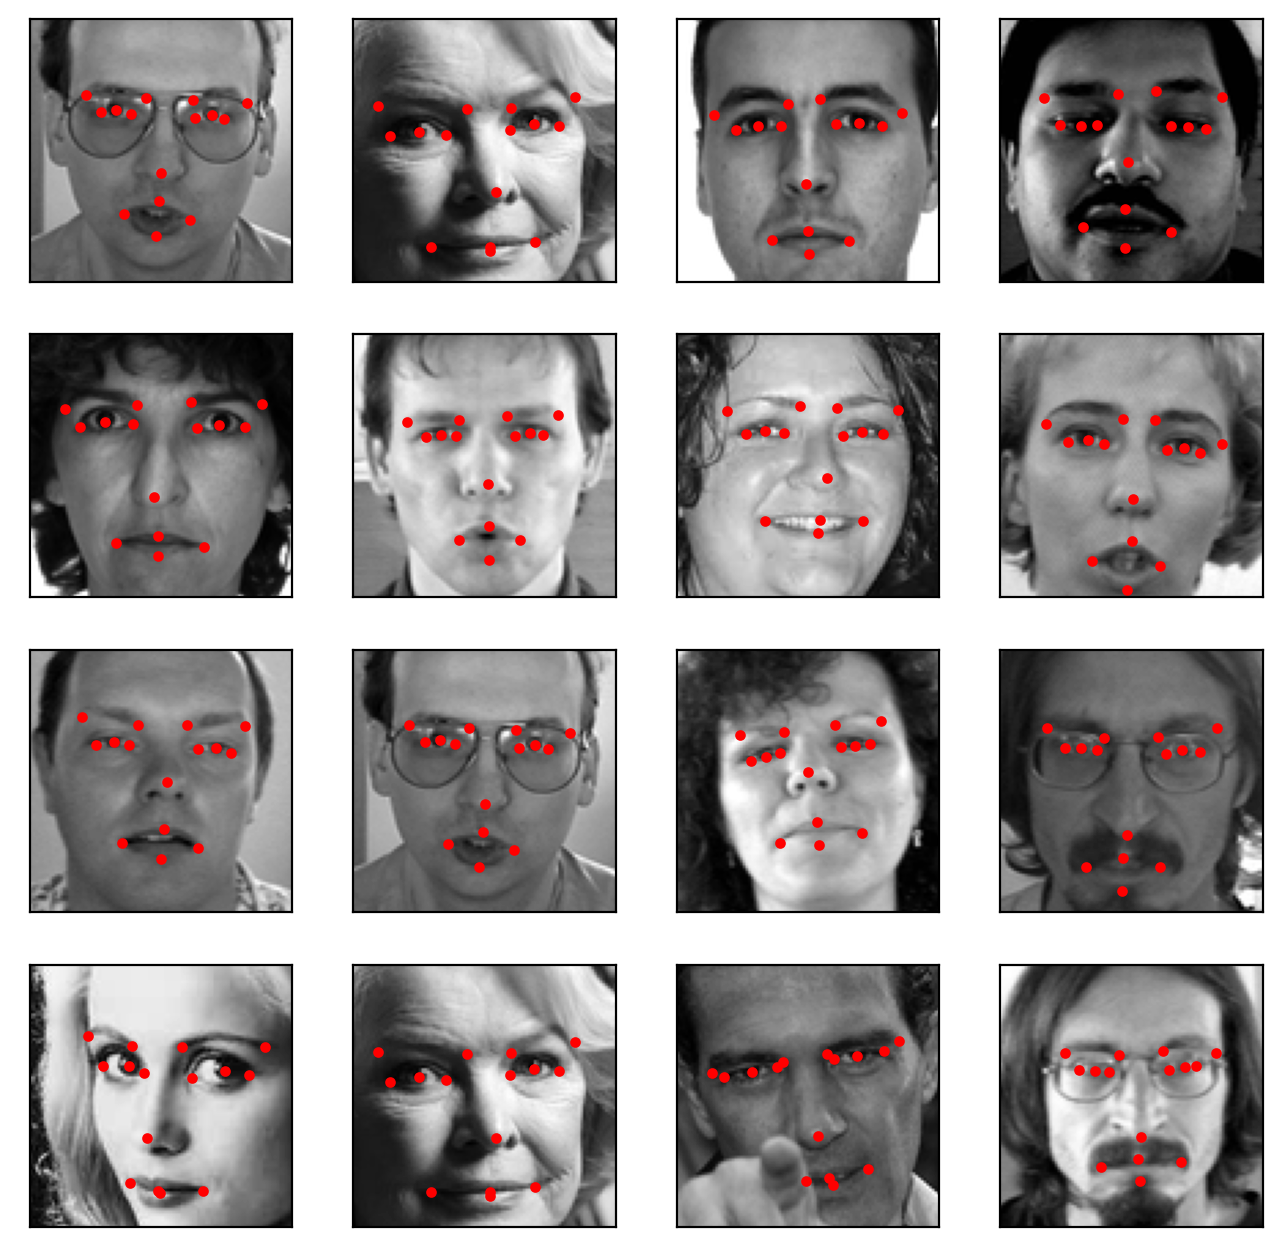

In [8]:
train_dataset = FacialKeyPointsDataset(train_data, apply_augmentations=False)
batch_images, batch_keypoints = train_dataset[0]
visualize_data(batch_images, batch_keypoints, n_rows=4, n_cols=4)

## Model Training, evaluation and inference

### Training base model

We train a base model that is inspired by the wide blocks used in the Inception family of models.

In [9]:
def inception_like_wide_block(input_layer, filter3, filter5):
    # 3x3 conv
    conv3 = tf.keras.layers.Conv2D(
        filter3, (3, 3), padding='same', activation='relu')(input_layer)
    bn3 = tf.keras.layers.BatchNormalization()(conv3)
    # 5x5 conv
    conv5 = tf.keras.layers.Conv2D(
        filter5, (5, 5), padding='same', activation='relu')(input_layer)
    bn5 = tf.keras.layers.BatchNormalization()(conv5)
    # 3x3 max pooling
    pool = tf.keras.layers.MaxPooling2D(
        (2,2), strides=(1,1), padding='same')(input_layer)
    # concatenate filters, assumes filters/channels last
    layer_out = tf.keras.layers.Concatenate(axis=-1)([bn3, bn5, pool])
    return layer_out


def build_model():
    input_image = tf.keras.Input(shape=(96, 96, 1))
    x1 = inception_like_wide_block(input_image, 64, 32)
    x1 = tf.keras.layers.MaxPooling2D(
        (3, 3), padding='same', strides=(2, 2) )(x1)
    x2 = inception_like_wide_block(x1, 64, 32)
    x2 = tf.keras.layers.MaxPooling2D(
        (3, 3), padding='same', strides=(2, 2) )(x2)
    x2_1 = inception_like_wide_block(x2, 96, 64)
    x2_1 = tf.keras.layers.MaxPooling2D(
        (3, 3), padding='same', strides=(2, 2) )(x2_1)  
    x3 = inception_like_wide_block(x2_1, 128, 64)
    x3 = tf.keras.layers.MaxPooling2D()(x3)
    x3_1 = inception_like_wide_block(x3, 256, 128)
    x3_1 = tf.keras.layers.GlobalAveragePooling2D()(x3_1)
    x4 = tf.keras.layers.Flatten()(x3_1)
    x4 = tf.keras.layers.Dense(1024, kernel_regularizer=l2(l2=0.03))(x4)
    x4 = tf.keras.layers.Dropout(0.2)(x4)
    pred = tf.keras.layers.Dense(30)(x4)
    return tf.keras.Model(
        inputs=input_image, outputs=pred, name='Inception_Like_Model'
    )


model = build_model()
model.summary()

Model: "Inception_Like_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 96, 96, 64)   256         conv2d[0][0]                     
_______________________________________________________________________________

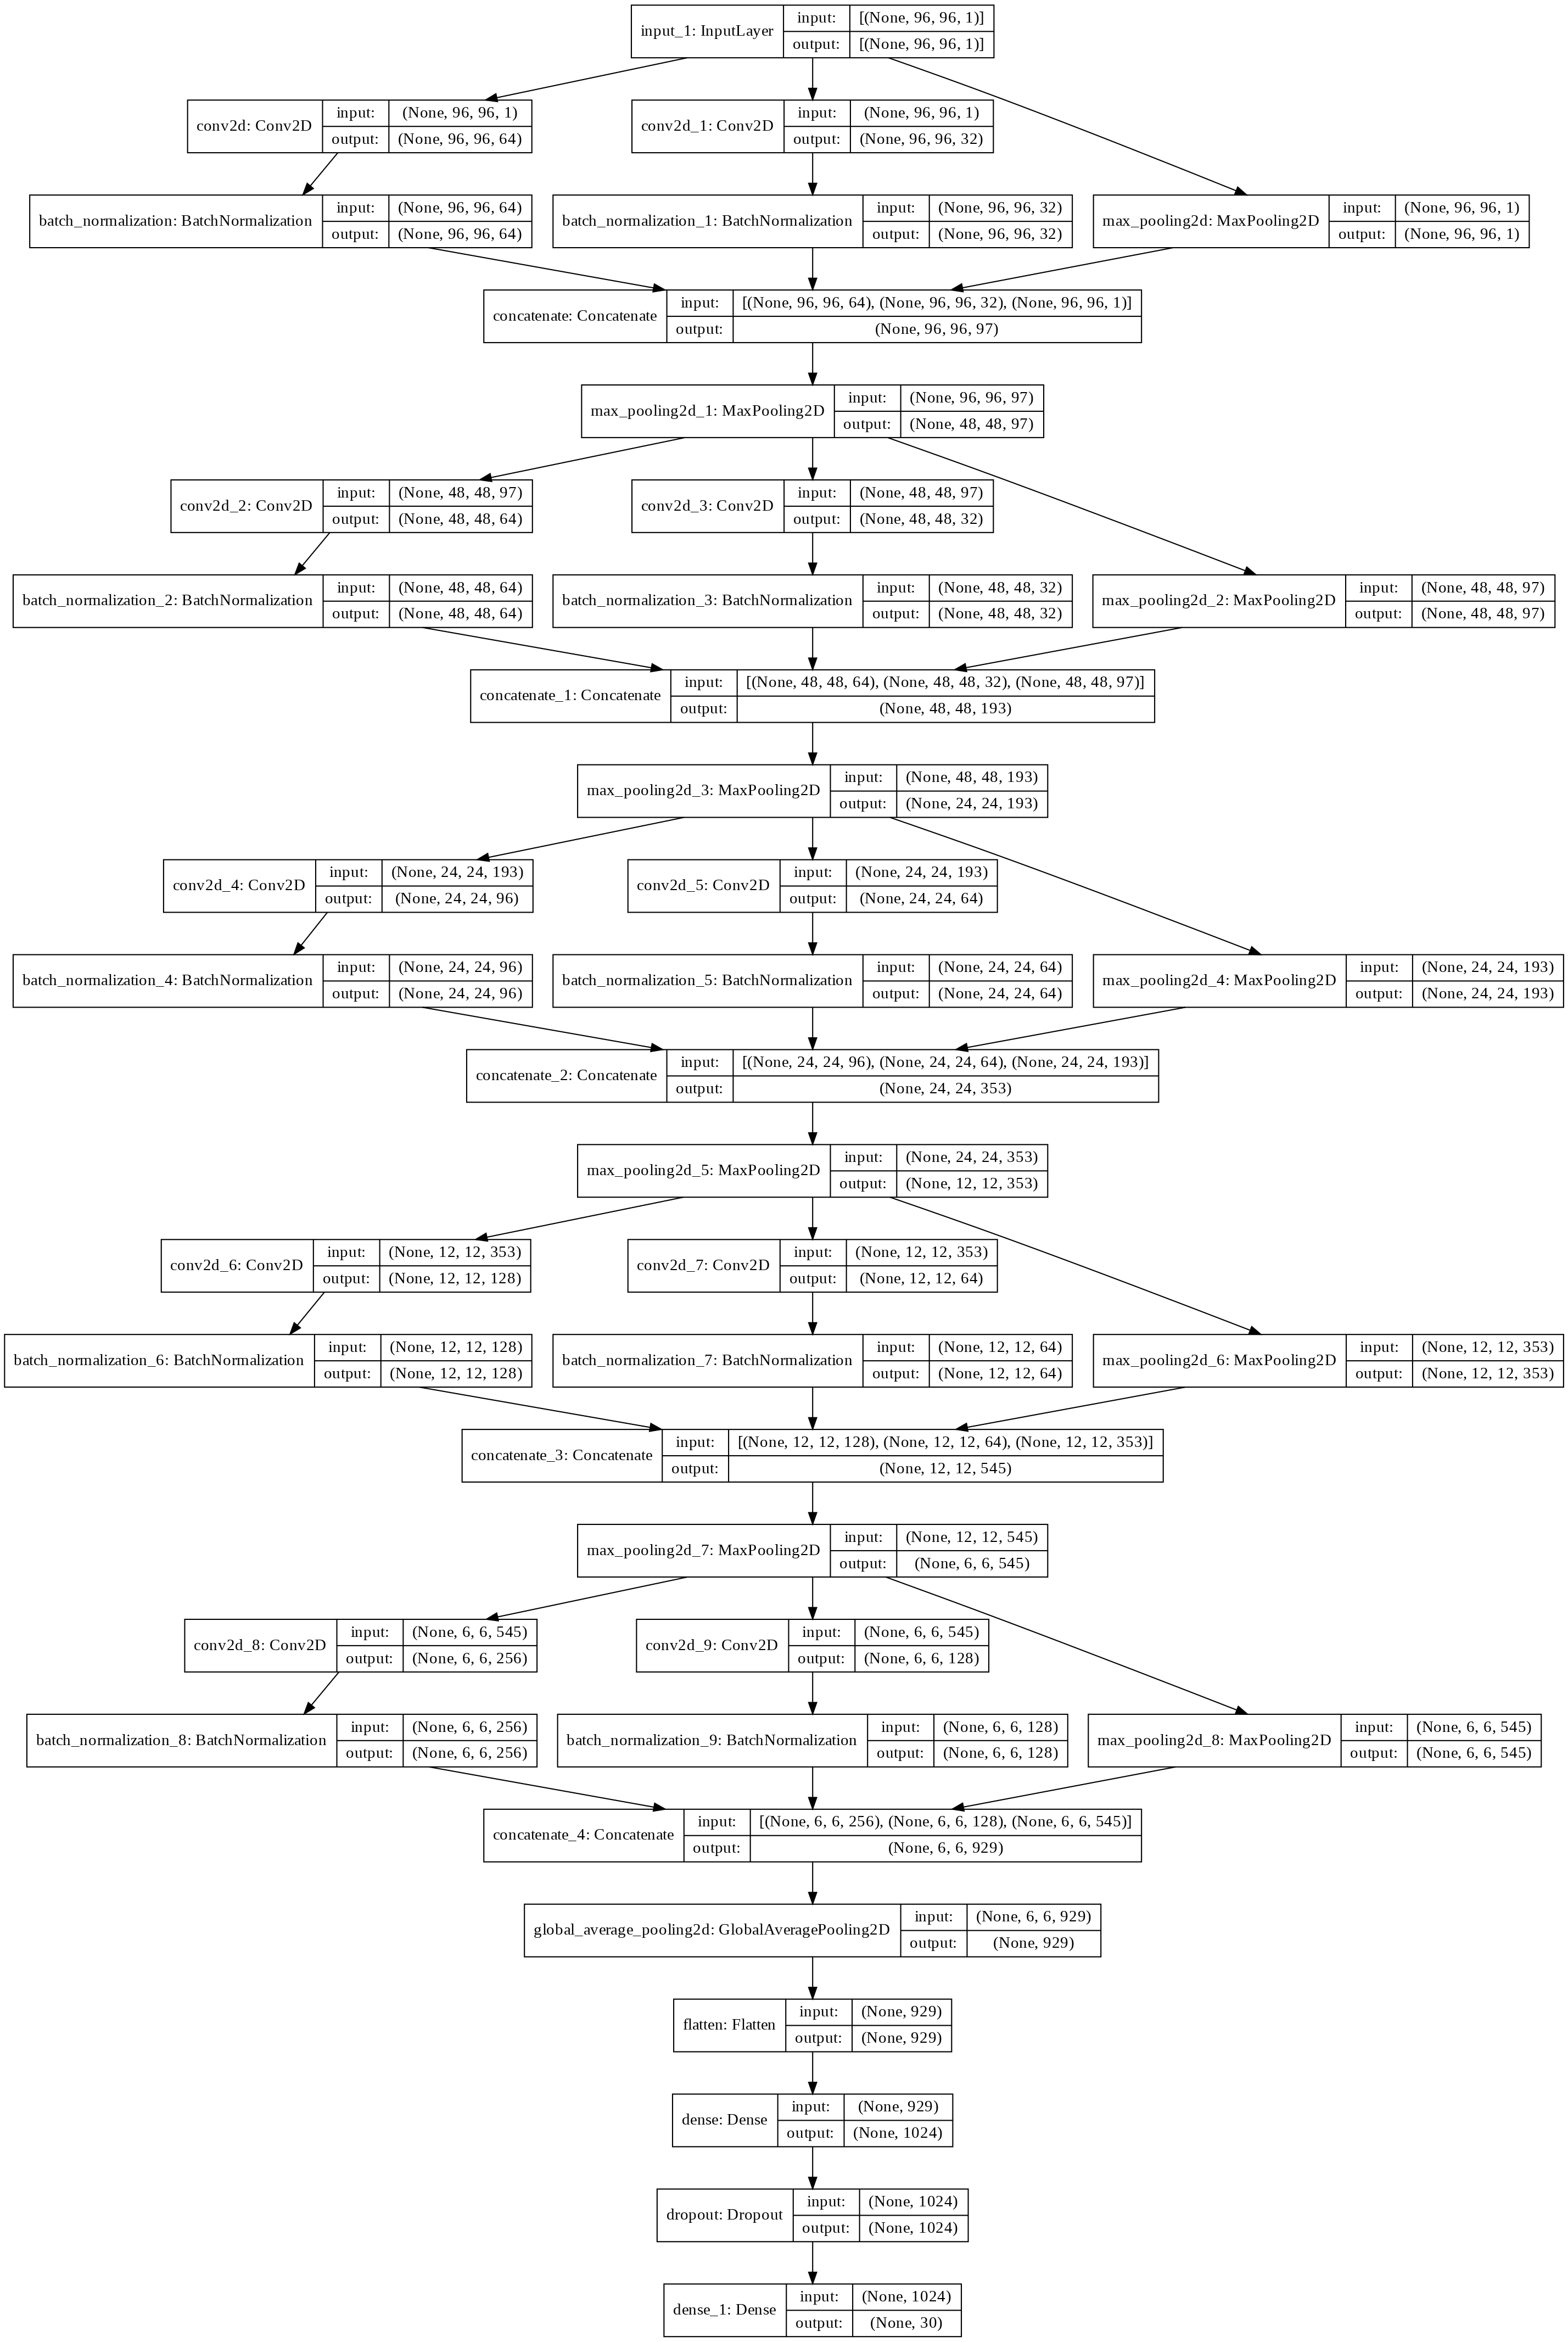

In [10]:
tf.keras.utils.plot_model(
    model, show_shapes=True, to_file="base_model.png", dpi=150)

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy']
)

train_dataset = FacialKeyPointsDataset(
    train_data, batch_size=64, apply_augmentations=True)
val_dataset = FacialKeyPointsDataset(
    val_data, batch_size=64, apply_augmentations=False)

history = model.fit(
    train_dataset, validation_data=val_dataset,
    epochs=30, batch_size=64, callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'base_model_weights.h5', monitor="val_loss",
            save_best_only=False, save_weights_only=True
        ), tf.keras.callbacks.EarlyStopping(
            monitor='loss', patience=5, mode='min'),
    ]
)

Epoch 1/30
31/31 [==============================] - 65s 2s/step - loss: 1115.3748 - accuracy: 0.3197 - val_loss: 2411.1121 - val_accuracy: 0.2570
Epoch 2/30
31/31 [==============================] - 38s 1s/step - loss: 118.3521 - accuracy: 0.4498 - val_loss: 1746.4257 - val_accuracy: 0.2523
Epoch 3/30
31/31 [==============================] - 38s 1s/step - loss: 71.0602 - accuracy: 0.5119 - val_loss: 1356.6227 - val_accuracy: 0.3458
Epoch 4/30
31/31 [==============================] - 34s 1s/step - loss: 62.8962 - accuracy: 0.5598 - val_loss: 1076.3409 - val_accuracy: 0.4766
Epoch 5/30
31/31 [==============================] - 28s 940ms/step - loss: 57.0511 - accuracy: 0.5679 - val_loss: 872.9988 - val_accuracy: 0.5140
Epoch 6/30
31/31 [==============================] - 20s 659ms/step - loss: 53.8917 - accuracy: 0.5990 - val_loss: 714.5422 - val_accuracy: 0.6215
Epoch 7/30
31/31 [==============================] - 13s 404ms/step - loss: 51.9403 - accuracy: 0.5911 - val_loss: 572.7123 - val_

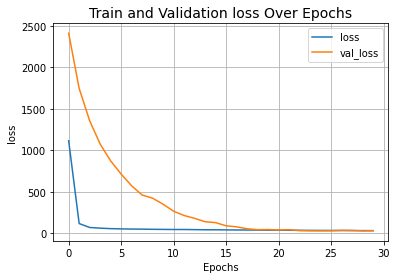

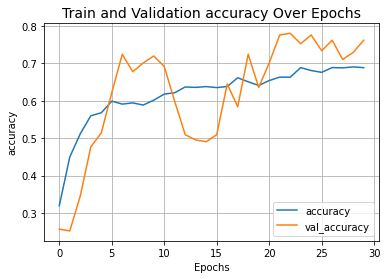

In [12]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [13]:
model.evaluate(val_dataset)

4/4 [==============================] - 0s 20ms/step - loss: 31.9662 - accuracy: 0.7617


[31.966161727905273, 0.7616822719573975]

In [14]:
# test_dataset = FacialKeyPointsDataset(test_data)
# predicted_keypoints = model.predict(test_dataset.images)
# visualize_data(test_dataset.images, predicted_keypoints)

## Quantization-aware Training

- In order to minimize the loss of accuracy from quantization, many methods that target INT4 and lower involve training the model in a way that considers the quantization. This means training with quantization of weights and activations included into the training procedure.

- The most common activation function in vision models is ReLU, which is unbounded. i.e, its dynamic range is not limited for positive inputs. This is very problematic for INT4 and below due to the very limited range and resolution. Therefore, most methods replace ReLU with another function which is bounded.

- Many methods do not quantize the first and last layer of the model. It has been observed the first convolutional layer is more sensitive to weights pruning. Similarly, critical operations such as Attention or layers connected with multiple blocks (skip connections) can be more sensitive to quantization.

- By Modifying the network structure, we can try to compensate for the loss of information due to quantization by using wider layers (more channels).

- Quantizing whole model might be useful if our use case is to deploy to a backend that only works well with fully quantized models like EdgeTPU v1. However, this is generally the most common reason for low accuracy in quantized networks. Due to the aforementioned reasons. Some layers in our model might be small where information is already packed very densely and is hence not very redundant. These layers if compressed, might lose crucial information learned by the network and result in a significant drop in accuracy.

![](https://i.imgur.com/eR4T7Ch.png)

### Training a partially quantized model from scratch

In [15]:
def inception_like_wide_block(input_layer, filter3, filter5, quantize=False):
    # 3x3 conv
    conv3 = tf.keras.layers.Conv2D(
        filter3, (3, 3),
        padding='same', activation='relu'
    )(input_layer) if not quantize else tfmot.quantization.keras.quantize_annotate_layer(
        tf.keras.layers.Conv2D(
            filter3, (3, 3),
            padding='same', activation='relu'
        )
    )(input_layer)
    bn3 = tf.keras.layers.BatchNormalization()(conv3)
    # 5x5 conv
    conv5 = tf.keras.layers.Conv2D(
        filter5, (5, 5),
        padding='same', activation='relu'
    )(input_layer) if not quantize else tfmot.quantization.keras.quantize_annotate_layer(
        tf.keras.layers.Conv2D(
            filter5, (5, 5),
            padding='same', activation='relu'
        )
    )(input_layer)
    bn5 = tf.keras.layers.BatchNormalization()(conv5)
    # 3x3 max pooling
    pool = tfmot.quantization.keras.quantize_annotate_layer(
        tf.keras.layers.MaxPooling2D(
            (2, 2), strides=(1, 1), padding='same'
        )
    )(input_layer) if quantize else tf.keras.layers.MaxPooling2D(
        (2, 2), strides=(1, 1), padding='same'
    )(input_layer)
    # concatenate filters, assumes filters/channels last
    layer_out = tf.keras.layers.Concatenate(axis=-1)([bn3, bn5, pool])
    return layer_out


def build_model():
    input_image = tf.keras.Input(shape=(96, 96, 1))
    x1 = inception_like_wide_block(input_image, 64, 32)
    x1 = tf.keras.layers.MaxPooling2D(
        (3, 3), padding='same', strides=(2, 2) )(x1)
    x2 = inception_like_wide_block(x1, 64, 32, quantize=True)
    x2 = tf.keras.layers.MaxPooling2D(
        (3, 3), padding='same', strides=(2, 2))(x2)
    x2_1 = inception_like_wide_block(x2, 96, 64, quantize=True)
    x2_1 = tf.keras.layers.MaxPooling2D(
        (3, 3), padding='same', strides=(2, 2) )(x2_1)  
    x3 = inception_like_wide_block(x2_1, 128, 64, quantize=True)
    x3 = tf.keras.layers.MaxPooling2D()(x3)
    x3_1 = inception_like_wide_block(x3, 256, 128, quantize=True)
    x3_1 = tf.keras.layers.GlobalAveragePooling2D()(x3_1)
    x4 = tf.keras.layers.Flatten()(x3_1)
    x4 = tf.keras.layers.Dense(1024, kernel_regularizer=l2(l2=0.03))(x4)
    x4 = tf.keras.layers.Dropout(0.2)(x4)
    pred = tf.keras.layers.Dense(30)(x4)
    return tf.keras.Model(
        inputs=input_image, outputs=pred, name='Inception_Like_Model'
    )

quantized_model = build_model()
quantized_model.summary()

Model: "Inception_Like_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 96, 96, 64)   640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 96, 96, 32)   832         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 96, 96, 64)   256         conv2d_10[0][0]                  
_______________________________________________________________________________

In [16]:
quantized_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy']
)

history = quantized_model.fit(
    train_dataset, validation_data=val_dataset,
    epochs=30, batch_size=64, callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'quantized_model_weights.h5', monitor="val_loss",
            save_best_only=True, save_weights_only=True
        ), tf.keras.callbacks.EarlyStopping(
            monitor='loss', patience=5, mode='min'),
    ]
)

Epoch 1/30
31/31 [==============================] - 14s 387ms/step - loss: 1254.1787 - accuracy: 0.1966 - val_loss: 2404.3608 - val_accuracy: 0.0000e+00
Epoch 2/30
31/31 [==============================] - 5s 180ms/step - loss: 115.4650 - accuracy: 0.4715 - val_loss: 1599.8711 - val_accuracy: 0.0047
Epoch 3/30
31/31 [==============================] - 6s 199ms/step - loss: 75.1409 - accuracy: 0.5367 - val_loss: 1207.1902 - val_accuracy: 0.0000e+00
Epoch 4/30
31/31 [==============================] - 12s 273ms/step - loss: 63.8751 - accuracy: 0.5611 - val_loss: 952.3758 - val_accuracy: 0.3505
Epoch 5/30
31/31 [==============================] - 5s 164ms/step - loss: 58.5819 - accuracy: 0.5570 - val_loss: 771.3284 - val_accuracy: 0.4907
Epoch 6/30
31/31 [==============================] - 6s 177ms/step - loss: 54.1273 - accuracy: 0.5797 - val_loss: 616.8914 - val_accuracy: 0.4766
Epoch 7/30
31/31 [==============================] - 10s 320ms/step - loss: 52.5144 - accuracy: 0.5850 - val_loss: 

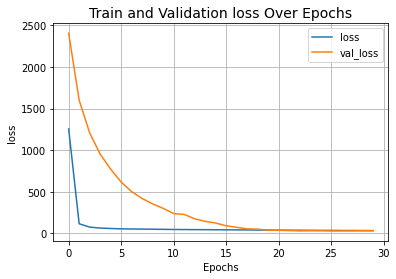

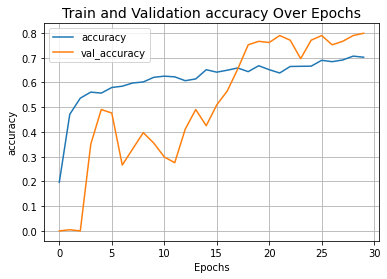

In [17]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [19]:
# with tfmot.quantization.keras.quantize_scope():
#     fully_quantized_model = tf.keras.models.load_model('./fully_quantized_model.h5')
quantized_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy']
)
quantized_model.evaluate(val_dataset)

4/4 [==============================] - 1s 20ms/step - loss: 31.6328 - accuracy: 0.7991


[31.632768630981445, 0.7990654110908508]

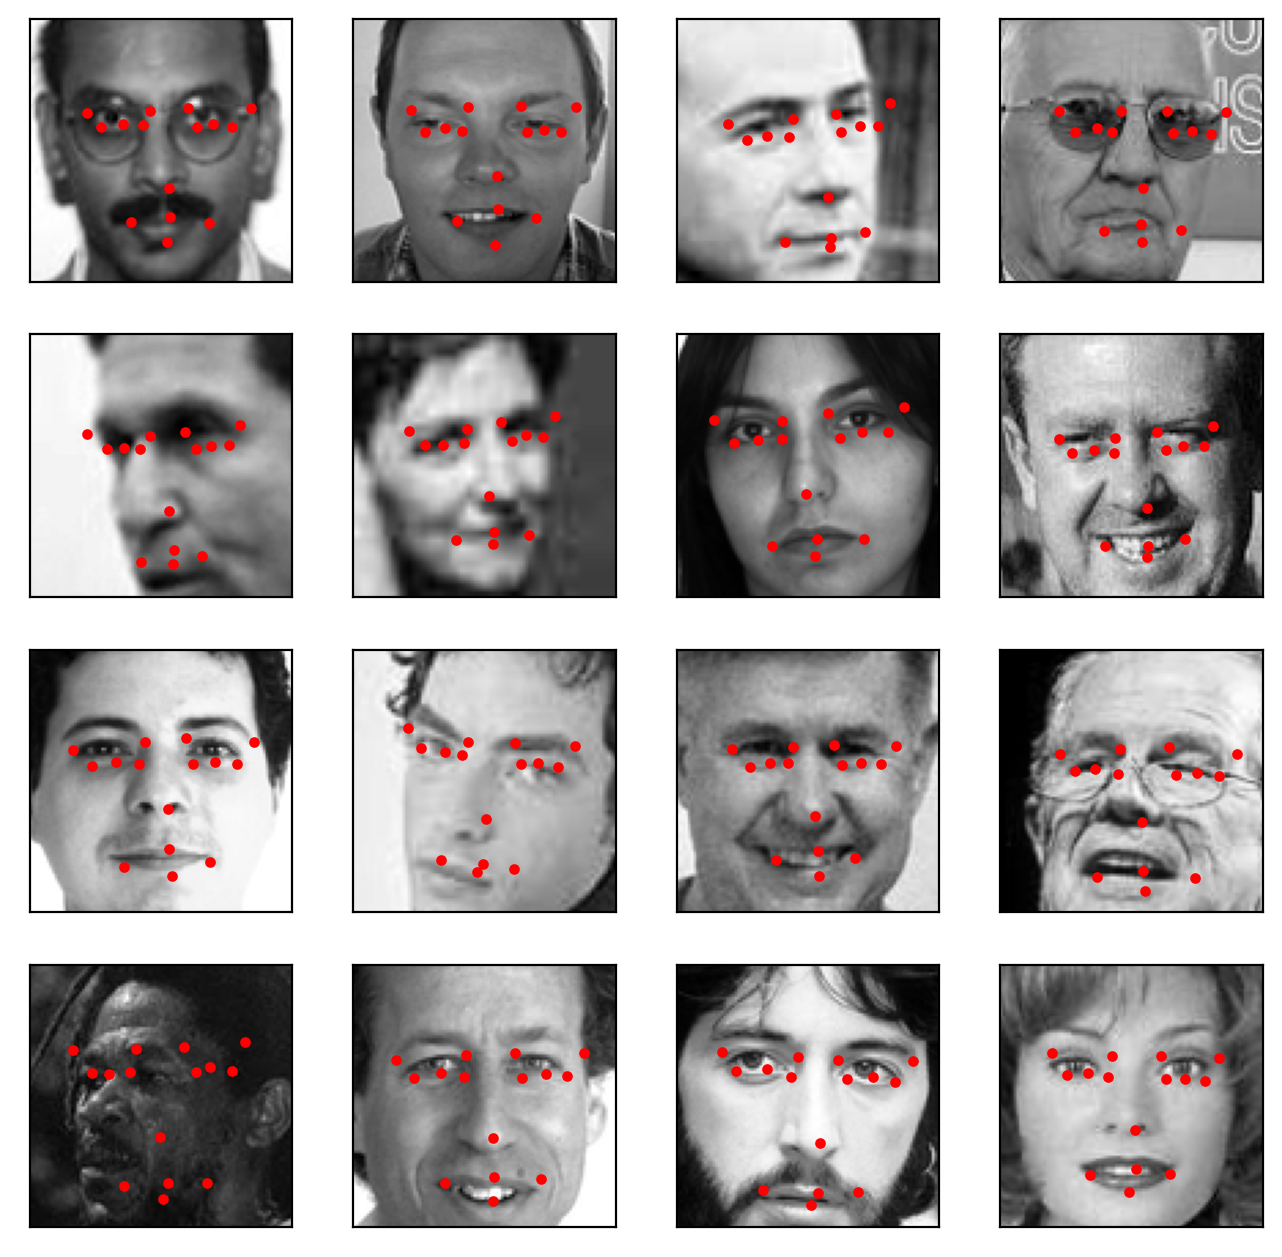

In [21]:
test_dataset = FacialKeyPointsDataset(test_data)
predicted_keypoints = quantized_model.predict(test_dataset.images)
visualize_data(test_dataset.images, predicted_keypoints)

In [27]:
quantized_model = build_model()
quantized_model.load_weights('./base_model_weights.h5')
quantized_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy']
)

history = quantized_model.fit(
    train_dataset, validation_data=val_dataset,
    epochs=50, batch_size=64, callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'quantized_model_weights.h5', monitor="val_loss",
            save_best_only=True, save_weights_only=True
        ), tf.keras.callbacks.EarlyStopping(
            monitor='loss', patience=5, mode='min'),
    ]
)

Epoch 1/30
31/31 [==============================] - 12s 344ms/step - loss: 34.4519 - accuracy: 0.6920 - val_loss: 36.3415 - val_accuracy: 0.5280
Epoch 2/30
31/31 [==============================] - 6s 197ms/step - loss: 32.1805 - accuracy: 0.6908 - val_loss: 35.5362 - val_accuracy: 0.7664
Epoch 3/30
31/31 [==============================] - 9s 289ms/step - loss: 31.4088 - accuracy: 0.6906 - val_loss: 32.6201 - val_accuracy: 0.6822
Epoch 4/30
31/31 [==============================] - 5s 166ms/step - loss: 30.3866 - accuracy: 0.6957 - val_loss: 31.0655 - val_accuracy: 0.6916
Epoch 5/30
31/31 [==============================] - 5s 162ms/step - loss: 29.7635 - accuracy: 0.7084 - val_loss: 29.6462 - val_accuracy: 0.7804
Epoch 6/30
31/31 [==============================] - 9s 291ms/step - loss: 29.1694 - accuracy: 0.7138 - val_loss: 27.7933 - val_accuracy: 0.6963
Epoch 7/30
31/31 [==============================] - 6s 182ms/step - loss: 28.3585 - accuracy: 0.7190 - val_loss: 26.8702 - val_accuracy

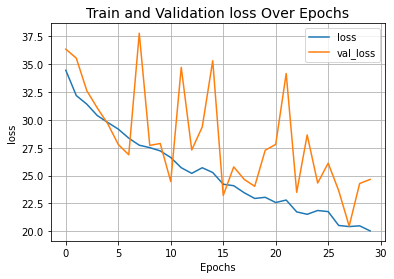

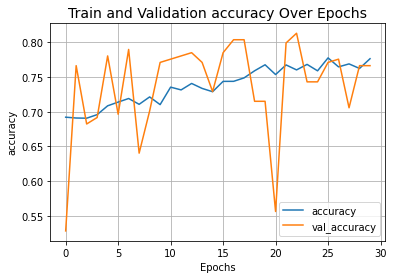

In [28]:
plot_result("loss")
plot_result("accuracy")

In [29]:
quantized_model.evaluate(val_dataset)

4/4 [==============================] - 0s 21ms/step - loss: 24.6602 - accuracy: 0.7664


[24.660171508789062, 0.7663551568984985]